In [737]:
import api_keys
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd
import seaborn as sns
from datetime import datetime, timedelta
from tqdm import tqdm, tqdm_notebook
import json

import time
import numpy as np
import matplotlib.pyplot as plt


#math stuff - may or may not use
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.diagnostic import linear_harvey_collier
from statsmodels.stats.diagnostic import spec_white

In [ ]:
# may need this: https://developer.spotify.com/documentation/web-api/reference/search/search/

In [466]:
sp = spotipy.Spotify(
    client_credentials_manager = SpotifyClientCredentials(
        client_id=api_keys.CLIENT_ID,
        client_secret=api_keys.CLIENT_SECRET
    )    
)

def get_the_playlists(date,offset):
    '''
    Get playlist ids for a particular day
    Inputs: date in ISO-8601 format
            offfset - page number
    Output: paired playlist ids with number of tracks
    '''
    return ([i['id'],i['snapshot_id'],i['tracks']['total']] for i in sp.featured_playlists(
        locale=None,
        country='US',
        timestamp=date,
        limit=50,
        offset=offset*50
    )['playlists']['items'])
    
def get_playlist_tracks(id_):
    '''
    Get the tracks for a spotify playlist.
    Input: playlist ID
    Output: list of song IDs
    '''
    return [i['track']['id'] for i in sp.user_playlist('spotify',id_)['tracks']['items']]

def get_song_features(ids):
    '''
    Get song features for each song in a list
    '''
    return pd.DataFrame(sp.audio_features(_)[0] for _ in ids)

def get_all_playlists():
    num_days = 1461 # that's 4 years
    start_date = datetime(2015,1,1,0,0)

    dates = ['T'.join(str(start_date + timedelta(hours=i*8)).split()) for i in range(int(num_days*3))]
    playlist_df = pd.DataFrame({0:[],1:[],2:[]})

    for date in tqdm_notebook(dates):
        while True:
            try:
                playlist_df = pd.concat([playlist_df,pd.DataFrame(list(get_the_playlists(date,0)))])
            except:
                time.sleep(30)
                continue
            break
    return playlist_df

def get_tune(search_string):
    attempts = 0
    while attempts < 3:
        try:
            return sp.search(user_df.iloc[0].search_string,type='track',limit=1)['tracks']['items'][0]['id']
        except:
            time.sleep(30)
            attempts += 1
            continue
        break
    return ''

# Get Featured Playlists

This data comes straight from the API

1. Get playlist metadata
2. Get each relevant playlist

### 1. Get playlist metadata

In [279]:
playlist_df = get_all_playlists()

retrying ...1secs
retrying ...1secs
retrying ...1secs


In [288]:
playlist_df.head()

,0,1,2
0,37i9dQZF1DXbcP8BbYEQaO,MTU2NDcxODQ2MCwwMDAwMDAwNDAwMDAwMTZjNTA3Y2VkNW...,71.0
1,37i9dQZF1DX4sWSpwq3LiO,MTU2NTEwNDU4NCwwMDAwMDA5NTAwMDAwMTZjNjc4MGI2Nz...,224.0
2,37i9dQZF1DX5DMh4a0MOAn,MTU1Nzk3MTMwOCwwMDAwMDAyZjAwMDAwMTZhYmU1MzhmNz...,55.0
3,37i9dQZF1DX2yvmlOdMYzV,MTU1ODY4NDg2MCwwMDAwMDAzNzAwMDAwMTZhZThkYjdlYm...,126.0
4,37i9dQZF1DX3Ogo9pFvBkY,MTU2NDE3ODYyNSwwMDAwMDAzOTAwMDAwMTZjMzA0ZmIyMT...,218.0


In [286]:
playlist_df.drop_duplicates().to_csv('data/featured_playlists.csv')

### 2. Get playlist songs

In [302]:
playlist_df = pd.read_csv('data/featured_playlists.csv', index_col=0)

In [303]:
playlist_df.head()

,0,1,2
0,37i9dQZF1DXbcP8BbYEQaO,MTU2NDcxODQ2MCwwMDAwMDAwNDAwMDAwMTZjNTA3Y2VkNW...,71.0
1,37i9dQZF1DX4sWSpwq3LiO,MTU2NTEwNDU4NCwwMDAwMDA5NTAwMDAwMTZjNjc4MGI2Nz...,224.0
2,37i9dQZF1DX5DMh4a0MOAn,MTU1Nzk3MTMwOCwwMDAwMDAyZjAwMDAwMTZhYmU1MzhmNz...,55.0
3,37i9dQZF1DX2yvmlOdMYzV,MTU1ODY4NDg2MCwwMDAwMDAzNzAwMDAwMTZhZThkYjdlYm...,126.0
4,37i9dQZF1DX3Ogo9pFvBkY,MTU2NDE3ODYyNSwwMDAwMDAzOTAwMDAwMTZjMzA0ZmIyMT...,218.0


In [321]:
print('playlists with less than 100 tracks:', playlist_df[playlist_df['2'] < 100].shape[0])
print('number of songs in all these playlists:', playlist_df[playlist_df['2'] < 100]['2'].sum())
print('unique playlists from those playlists:', playlist_df[playlist_df['2'] < 100]['0'].nunique())
print('unique playlists from all playlists:', playlist_df['0'].nunique())

playlists with less than 100 tracks: 600
number of songs in all these playlists: 39843.0
unique playlists from those playlists: 86
unique playlists from all playlists: 138


86 is not a lot...

# Get User Playlists

In [369]:
user_df = pd.read_csv('data/user_dataset.csv',error_bad_lines=False,warn_bad_lines=False)

#### Rename Columns

In [370]:
user_df.rename(index=str, columns={
        ' "artistname"': "artist",
        ' "trackname"': "trackname",
        ' "playlistname"': "playlistname"
    },inplace=True)

#### Create User-Playlistname Column

In [371]:
user_df['user_playlistname'] = user_df.user_id + '--' + user_df.playlistname

#### Get Playlist Size

In [372]:
user_df['playlist_size'] = user_df.groupby('user_playlistname')['user_playlistname'].transform('size')

#### Get Playlist Position

In [373]:
user_df['playlist_position'] = user_df.groupby('user_playlistname').cumcount(ascending=True)

In [374]:
user_df['user_playlistname'].nunique()

231804

#### Between 10 and 50 songs

In [378]:
user_df = user_df[user_df.playlist_size >= 10]
user_df = user_df[user_df.playlist_size <= 50]

In [379]:
user_df['user_playlistname'].nunique()

143388

#### Take care of N/As

In [382]:
user_df['playlist_null_count'] = \
    user_df.groupby('user_playlistname').artist.transform(lambda group: group.isnull().sum())

In [388]:
user_df = user_df[user_df.playlist_null_count == 0].dropna()

#### Search string column
https://github.com/plamere/spotipy/blob/master/examples/search.py

In [392]:
user_df['search_string'] = user_df['artist'] + ' ' + user_df['trackname']

In [395]:
user_df['search_string'].nunique()

951163

#### Done... ?

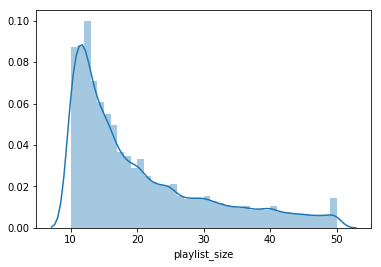

In [397]:
sns.distplot(user_df[['user_playlistname','playlist_size']].drop_duplicates().dropna()['playlist_size'],bins=range(10,51))

#### Search stuff

In [412]:
#example
r = sp.search(user_df.iloc[0].search_string)['tracks']['items'][0]['id']
print(r)

1KlDcHrlDPUJJPmMup3tUp


In [417]:
all_tracks = user_df[['search_string']].drop_duplicates().reset_index(drop=True)

In [428]:
from tqdm.auto import tqdm
tqdm.pandas()
all_tracks['track_id'] = all_tracks.search_string.progress_apply(lambda string: get_tune(string))

retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs


In [475]:
all_tracks.head()

,search_string,track_id
0,Noah And The Whale 5 Years Time,1KlDcHrlDPUJJPmMup3tUp
1,Noel Gallagher's High Flying Birds AKA... What...,1KlDcHrlDPUJJPmMup3tUp
2,Pearl Jam Alive,1KlDcHrlDPUJJPmMup3tUp
3,Tom Petty And The Heartbreakers American Girl,1KlDcHrlDPUJJPmMup3tUp
4,Bruce Springsteen Atlantic City,1KlDcHrlDPUJJPmMup3tUp


# OMG

In [521]:
def get_tune(ss):
    try:
        return sp.search(ss,limit=1)['tracks']['items'][0]['id']
    except:
        return ''

In [548]:
#WARNING: This cell commits one of the cardinal sins of Pandas.

#wait - why is he using a for loop with .loc ...
#great question! this is usually a much less efficient way to use functions across a dataframe
#generally, you want to use the .apply() method
#this has not been working for iterative API calls however.
#I think this has something to do with how the SpotiPy library works with .apply()
#When using .apply(), it will refer back to the first element of the column at each iteration.
#This can lead to undesired behavior.
#More here: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html

start = 0

# old code
# for row,ss in tqdm(enumerate(all_tracks['search_string'][start:].to_list())):
#     all_tracks.loc[row+start,'track_id'] = get_tune(ss)

# new code - faster
res = []
for row,ss in tqdm(enumerate(all_tracks['search_string'][start:].to_list())):
    res.append(get_tune(ss))
    if row == 0:
        pass
    elif row == 10:
        all_tracks.loc[0:10,'track_id'] = res #only works if start = 0
        res.clear()
    elif row % 10 == 0:
        all_tracks.loc[(row+startstart-10+1):(row+start),'track_id'] = res
        res.clear()

retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...2secs
retrying ...1secs
retrying ...3secs
retrying ...1secs
retrying ...3secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs


In [558]:
all_tracks.to_csv('data/all_song_ids.csv')

In [557]:
all_tracks.head(15)

,search_string,track_id
0,Noah And The Whale 5 Years Time,1KlDcHrlDPUJJPmMup3tUp
1,Noel Gallagher's High Flying Birds AKA... What...,5mljJfOTZR3nF4ExmRLTjv
2,Pearl Jam Alive,1L94M3KIu7QluZe63g64rv
3,Tom Petty And The Heartbreakers American Girl,7MRyJPksH3G2cXHN8UKYzP
4,Bruce Springsteen Atlantic City,1Vp8U39YNsDfd6yVuaUq12
5,Madness Baggy Trousers,3Sbnhrpec0ULbeWBsA6GS6
6,Pearl Jam Black,5Xak5fmy089t0FYmh3VJiY
7,Bruce Springsteen Born to Run,6hTcuIQa0sxrrByu9wTD7s
8,Spector Chevy Thunder,6ikzdvfsPbdaGpXmeEeaK2
9,Miles Kane Come Closer,20uVZbYFKshjrdDHcVy9w9


# Now for the Metadata
Get all them _values_

In [559]:
sp.audio_features(all_tracks.loc[0,'track_id'])

[{'danceability': 0.8,
  'energy': 0.559,
  'key': 0,
  'loudness': -7.11,
  'mode': 1,
  'speechiness': 0.116,
  'acousticness': 0.335,
  'instrumentalness': 0,
  'liveness': 0.148,
  'valence': 0.788,
  'tempo': 121.967,
  'type': 'audio_features',
  'id': '1KlDcHrlDPUJJPmMup3tUp',
  'uri': 'spotify:track:1KlDcHrlDPUJJPmMup3tUp',
  'track_href': 'https://api.spotify.com/v1/tracks/1KlDcHrlDPUJJPmMup3tUp',
  'analysis_url': 'https://api.spotify.com/v1/audio-analysis/1KlDcHrlDPUJJPmMup3tUp',
  'duration_ms': 214920,
  'time_signature': 4}]

In [730]:
def get_song_features(ids,list_=None):#,dataframe=None):
    '''
    Get song features for each song in a list
    '''
    for id_ in tqdm(ids):
        try:
            list_.append(sp.audio_features(id_)[0])
        except:
            list_.append(id_)
            
            
#        return [sp.audio_features(_)[0] for _ in tqdm(ids)]
# #         return pd.DataFrame(sp.audio_features(_)[0] for _ in tqdm(ids))
#     else:
#         print('this code does not work yet')
#         for id_ in tqdm(ids):
#             if id_ != '':
#                 dataframe.update(
#                     pd.concat(
#                         dataframe,
#                         pd.DataFrame(sp.audio_features(_)[0])
#                     ),
#                     overwrite=False,
#                     ignore_index=True
#                 )
                    

In [731]:
features_list = []

In [734]:
get_song_features(all_tracks.track_id.to_list()[67000:],list_=features_list)

retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs


In [739]:
# with open("features_list_2.json", "w") as output:
#     output.write(str(features_list))
    
with open('features_list_3.json', 'w') as f:
    json.dump(features_list, f)

In [751]:
with open('features_list_3.json') as json_file:
    j = json.load(json_file)

In [778]:
j_clean = list(filter(None, j)) 

In [782]:
j_clean = list(filter(lambda i:not(type(i) is str), j_clean))

In [783]:
features_df = pd.DataFrame(j_clean)

In [785]:
features_df.shape

(765244, 18)

In [786]:
features_df.head()

,acousticness,analysis_url,danceability,duration_ms,energy,id,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,track_href,type,uri,valence
0,0.335000,https://api.spotify.com/v1/audio-analysis/1KlD...,0.800,214920,0.559,1KlDcHrlDPUJJPmMup3tUp,0.000000,0,0.1480,-7.110,1,0.1160,121.967,4.0,https://api.spotify.com/v1/tracks/1KlDcHrlDPUJ...,audio_features,spotify:track:1KlDcHrlDPUJJPmMup3tUp,0.788
1,0.000297,https://api.spotify.com/v1/audio-analysis/5mlj...,0.447,264480,0.927,5mljJfOTZR3nF4ExmRLTjv,0.362000,6,0.0972,-3.300,0,0.0508,119.034,4.0,https://api.spotify.com/v1/tracks/5mljJfOTZR3n...,audio_features,spotify:track:5mljJfOTZR3nF4ExmRLTjv,0.104
2,0.007520,https://api.spotify.com/v1/audio-analysis/1L94...,0.284,340907,0.875,1L94M3KIu7QluZe63g64rv,0.000461,11,0.4020,-6.069,0,0.0422,75.009,4.0,https://api.spotify.com/v1/tracks/1L94M3KIu7Ql...,audio_features,spotify:track:1L94M3KIu7QluZe63g64rv,0.595
3,0.448000,https://api.spotify.com/v1/audio-analysis/7MRy...,0.550,214733,0.824,7MRyJPksH3G2cXHN8UKYzP,0.000127,2,0.3660,-5.988,1,0.0334,114.512,4.0,https://api.spotify.com/v1/tracks/7MRyJPksH3G2...,audio_features,spotify:track:7MRyJPksH3G2cXHN8UKYzP,0.777
4,0.311000,https://api.spotify.com/v1/audio-analysis/1Vp8...,0.475,236653,0.429,1Vp8U39YNsDfd6yVuaUq12,0.000000,4,0.3760,-10.577,1,0.0367,108.034,4.0,https://api.spotify.com/v1/tracks/1Vp8U39YNsDf...,audio_features,spotify:track:1Vp8U39YNsDfd6yVuaUq12,0.340


In [787]:
features_df.to_csv('song_features.csv')